## Visualização dos dados

Nesse notebook são feitas as visualizações dos dados

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from utils.load_csv import load_csv
from utils.load_shp import load_shp
from utils.save_graph import save_graph

In [2]:
df_ppa_fonte = load_csv("ppa_fonte.csv")

df_ppa_reg = load_csv("ppa_reg.csv")

gdf_subprefs = load_shp("subprefs.shp")

#### Gráfico 1

Tratamento +

In [3]:
df_ppa_fonte_grafico1 = df_ppa_fonte.rename(columns = lambda x: x.strip().replace("'", "").replace(" ", ""))

df_ppa_fonte_grafico1 = df_ppa_fonte_grafico1[["descricaodafuncao", 
                                               "2022", 
                                               "2023", 
                                               "2024", 
                                               "2025"]]

df_ppa_fonte_grafico1 = df_ppa_fonte_grafico1.groupby("descricaodafuncao").sum().T

In [4]:
agrupamentos = {"Urbanismo e Habitação": ["Urbanismo", "Habitação"],
                "Saneamento e Gestão Ambiental": ["Saneamento", "Gestão Ambiental"]}

for nova_coluna, origens in agrupamentos.items():
    df_ppa_fonte_grafico1[nova_coluna] = df_ppa_fonte_grafico1[origens].sum(axis = 1)

df_ppa_fonte_grafico1.drop(columns = sum(agrupamentos.values(), []), inplace = True)

In [5]:
funcoes = ["Saúde", 
           "Educação", 
           "Assistência Social",
           "Urbanismo e Habitação", 
           "Saneamento e Gestão Ambiental"]

col_outros = [col for col in df_ppa_fonte_grafico1.columns if col not in funcoes]

df_ppa_fonte_grafico1["Outros"] = df_ppa_fonte_grafico1[col_outros].sum(axis = 1)

df_ppa_fonte_grafico1 = df_ppa_fonte_grafico1[funcoes + ["Outros"]]

In [6]:
df_percentual = df_ppa_fonte_grafico1.div(df_ppa_fonte_grafico1.sum(axis = 1), axis = 0) * 100

Plot

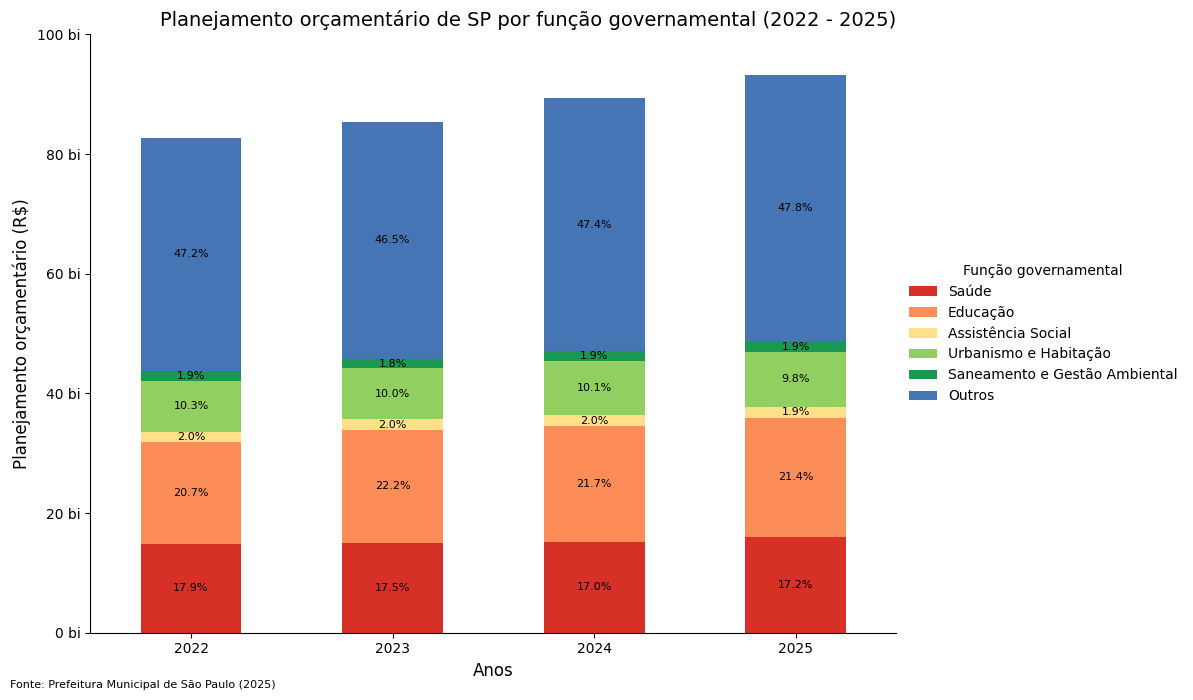

In [7]:
fig, ax = plt.subplots(figsize = (12, 7))

df_ppa_fonte_grafico1.plot(kind = "bar", 
                           stacked = True, 
                           ax = ax, 
                           color = ["#d73027",
                                    "#fc8d59", 
                                    "#fee08b", 
                                    "#91cf60", 
                                    "#1a9850", 
                                    "#4575b4"])

for i, coluna in enumerate(df_ppa_fonte_grafico1.columns):
    acumulado = df_ppa_fonte_grafico1.iloc[:, :i].sum(axis = 1)
    for j, (valor, perc) in enumerate(zip(df_ppa_fonte_grafico1[coluna], df_percentual[coluna])):
        if valor > 0:
            ax.text(j, 
                    acumulado.iloc[j] + valor / 2, 
                    f"{perc:.1f}%", 
                    ha = "center", 
                    va = "center", 
                    fontsize = 8)

ax.set_title("Planejamento orçamentário de SP por função governamental (2022 - 2025)", loc = "right", fontsize = 14)

ax.set_ylabel("Planejamento orçamentário (R$)", fontsize = 12)

ax.set_xlabel("Anos", fontsize = 12)

ax.set_xticks(range(len(df_ppa_fonte_grafico1.index)))

ax.set_xticklabels(df_ppa_fonte_grafico1.index, rotation = 0)

ax.legend(title = "Função governamental", bbox_to_anchor = (1, 0.5), loc = "center left", frameon = False)

ax.spines["top"].set_visible(False)

ax.spines["right"].set_visible(False)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.0f} bi'))

plt.ylim(0, 100e9)

plt.figtext(0.01, 0.01, "Fonte: Prefeitura Municipal de São Paulo (2025)", ha = "left", fontsize = 8)

plt.tight_layout()

plt.show()

save_graph(fig, "ppa_funcao_barras.png")

#### Mapas

Tratamento +

In [8]:
df_grouped_mapas = df_ppa_reg.groupby("descricao prefeitura regional")[["valor 2022", "valor 2023", "valor 2024", "valor 2025"]].sum().reset_index()

gdf_mapa = gdf_subprefs.merge(df_grouped_mapas, 
                              how = "left", 
                              left_on = "nm_subpref", 
                              right_on = "descricao prefeitura regional")

In [9]:
max_abs = gdf_mapa[["valor 2022", "valor 2023", "valor 2024", "valor 2025"]].max().max()

max_abs

np.float64(2371020731.0)

Plots

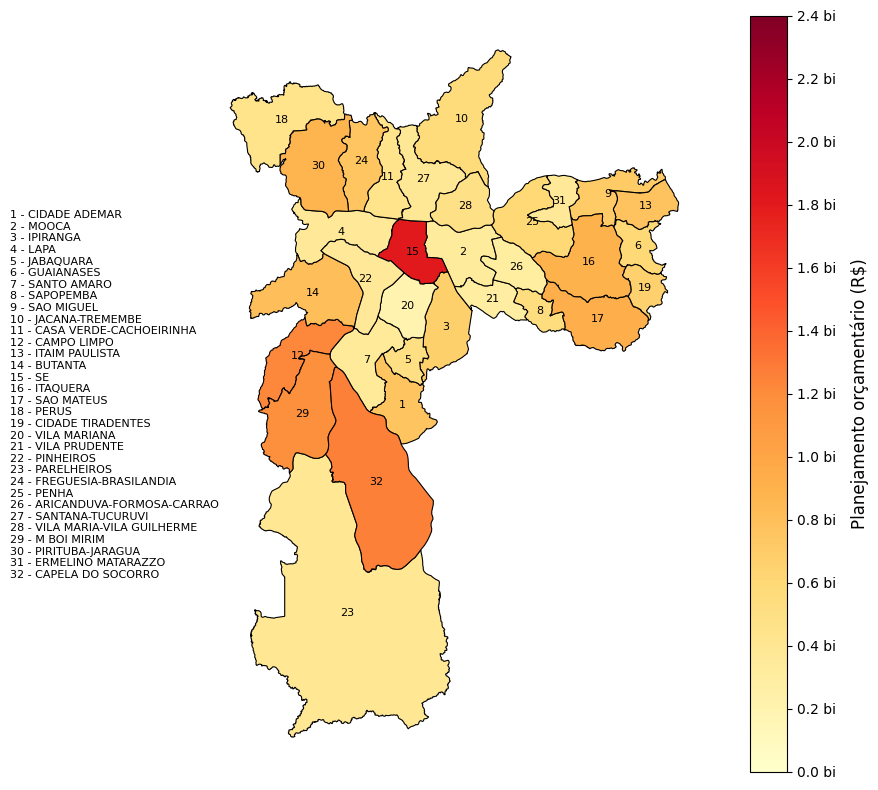

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot principal
gdf_mapa.plot(column="valor 2022",
              cmap="YlOrRd",
              linewidth=0.8,
              edgecolor="black",
              legend=True,
              ax=ax,
              vmin=0,
              vmax=2.4e9)

# Título
#ax.set_title("Planejamento orçamentário de SP por subprefeituras (2022)", fontsize=14)

# Colorbar
colorbar = ax.get_figure().get_axes()[1]
ticks = np.arange(0, 2.5e9, 0.2e9)
colorbar.yaxis.set_ticks(ticks)
colorbar.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.1f} bi'))
colorbar.set_ylabel("Planejamento orçamentário (R$)", fontsize=12, labelpad=10)
colorbar.set_ylim(0, 2.4e9)

# Numeração nas subprefeituras
for idx, row in gdf_mapa.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, str(idx + 1), 
            color='black', fontsize=8, ha='center', va='center')

# Tabela com nomes e numeração
tabela_df = gdf_mapa.reset_index()[["index", "nm_subpref"]]  # ajuste nome da coluna
tabela_df["index"] = tabela_df["index"] + 1
tabela_df = tabela_df.sort_values("index")

tabela_texto = [f'{int(row["index"])} - {row["nm_subpref"]}' for _, row in tabela_df.iterrows()]
tabela_str = "\n".join(tabela_texto)

plt.figtext(0.1, 0.5, tabela_str, fontsize=8, ha="left", va="center")
#0.6, 0.28

# Move o mapa
#pos = ax.get_position()
#ax.set_position([pos.x0 - -0.5, pos.y0, pos.width, pos.height])

# Fonte e layout
#plt.figtext(0.5, 0.01, "Fonte: Prefeitura Municipal de São Paulo (2022)", ha="center", fontsize=8)
ax.axis("off")
plt.tight_layout()
plt.show()

#save_graph(fig, "mapa_ppa_2022_numerado.png")

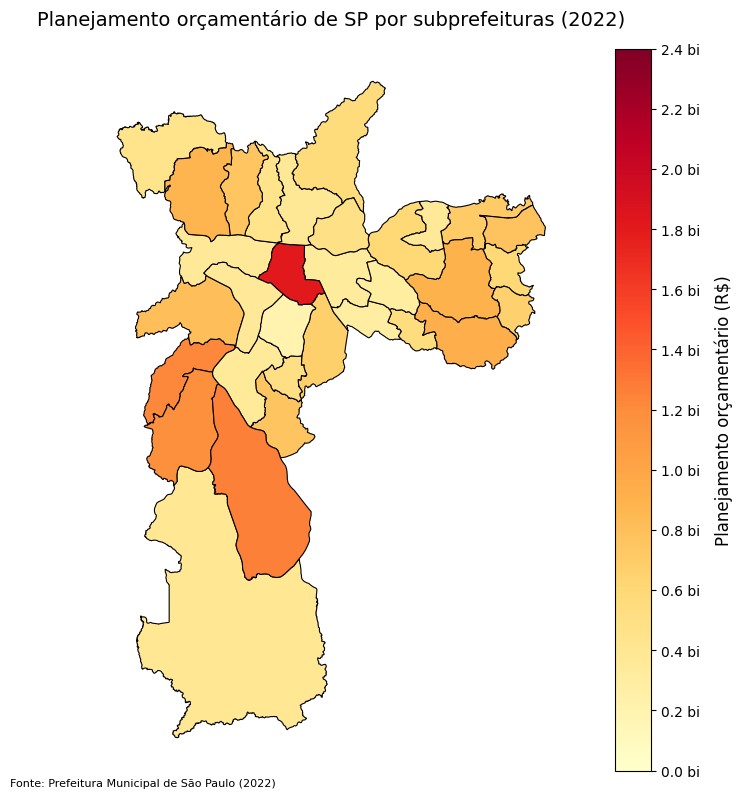

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

gdf_mapa.plot(column = "valor 2022",
              cmap = "YlOrRd",
              linewidth = 0.8,
              edgecolor = "black",
              legend = True,
              ax = ax,
              vmin = 0,
              vmax = 2.4e9)

ax.set_title("Planejamento orçamentário de SP por subprefeituras (2022)", fontsize = 14)

colorbar = ax.get_figure().get_axes()[1]

ticks = np.arange(0, 2.5e9, 0.2e9)

colorbar.yaxis.set_ticks(ticks)

colorbar.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.1f} bi'))

colorbar.set_ylabel("Planejamento orçamentário (R$)", fontsize = 12, labelpad = 10)

colorbar.set_ylim(0, 2.4e9)

plt.figtext(0.5, 0.01,
            "Fonte: Prefeitura Municipal de São Paulo (2022)",
            ha = "right",
            fontsize = 8)

ax.axis("off")

plt.tight_layout()

plt.show()

save_graph(fig, "mapa_ppa_2022.png")

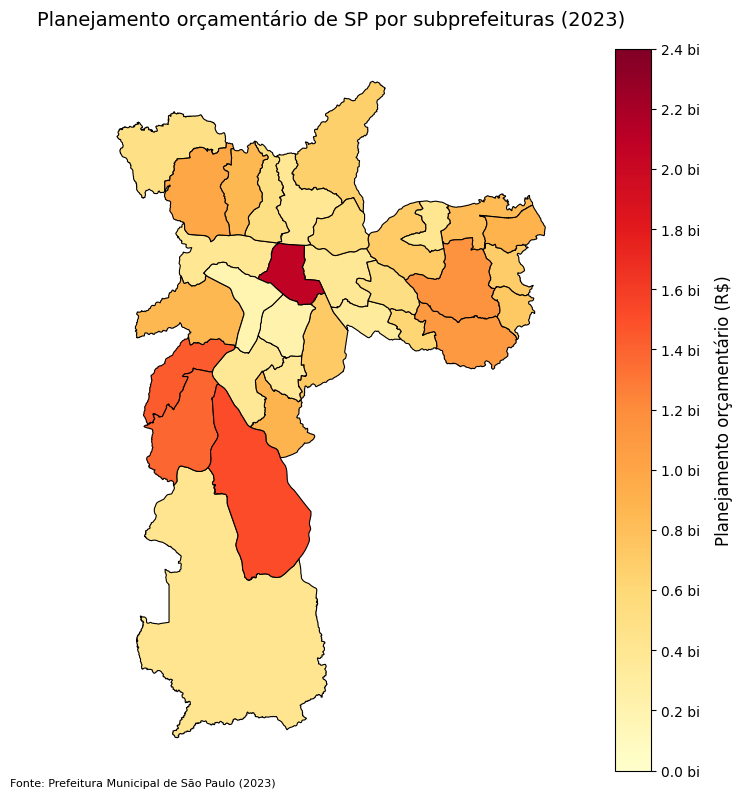

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

gdf_mapa.plot(column = "valor 2023",
              cmap = "YlOrRd",
              linewidth = 0.8,
              edgecolor = "black",
              legend = True,
              ax = ax,
              vmin = 0,
              vmax = 2.4e9)

ax.set_title("Planejamento orçamentário de SP por subprefeituras (2023)", fontsize = 14)

colorbar = ax.get_figure().get_axes()[1]

ticks = np.arange(0, 2.5e9, 0.2e9)

colorbar.yaxis.set_ticks(ticks)

colorbar.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.1f} bi'))

colorbar.set_ylabel("Planejamento orçamentário (R$)", fontsize = 12, labelpad = 10)

colorbar.set_ylim(0, 2.4e9)

plt.figtext(0.5, 0.01,
            "Fonte: Prefeitura Municipal de São Paulo (2023)",
            ha = "right",
            fontsize = 8)

ax.axis("off")

plt.tight_layout()

plt.show()

save_graph(fig, "mapa_ppa_2023.png")

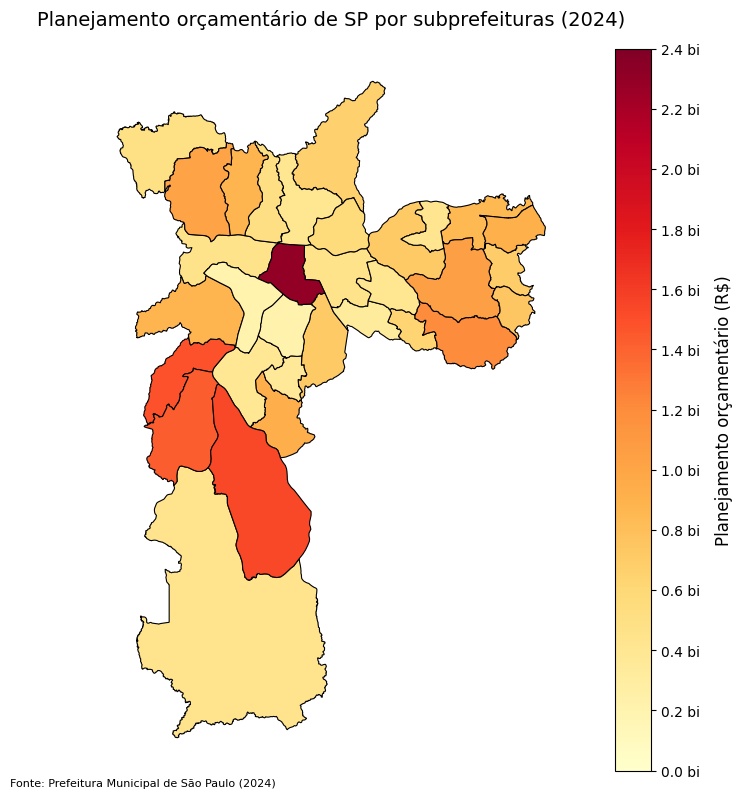

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

gdf_mapa.plot(column = "valor 2024",
              cmap = "YlOrRd",
              linewidth = 0.8,
              edgecolor = "black",
              legend = True,
              ax = ax,
              vmin = 0,
              vmax = 2.4e9)

ax.set_title("Planejamento orçamentário de SP por subprefeituras (2024)", fontsize = 14)

colorbar = ax.get_figure().get_axes()[1]

ticks = np.arange(0, 2.5e9, 0.2e9)

colorbar.yaxis.set_ticks(ticks)

colorbar.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.1f} bi'))

colorbar.set_ylabel("Planejamento orçamentário (R$)", fontsize = 12, labelpad = 10)

colorbar.set_ylim(0, 2.4e9)

plt.figtext(0.5, 0.01,
            "Fonte: Prefeitura Municipal de São Paulo (2024)",
            ha = "right",
            fontsize = 8)

ax.axis("off")

plt.tight_layout()

plt.show()

save_graph(fig, "mapa_ppa_2024.png")

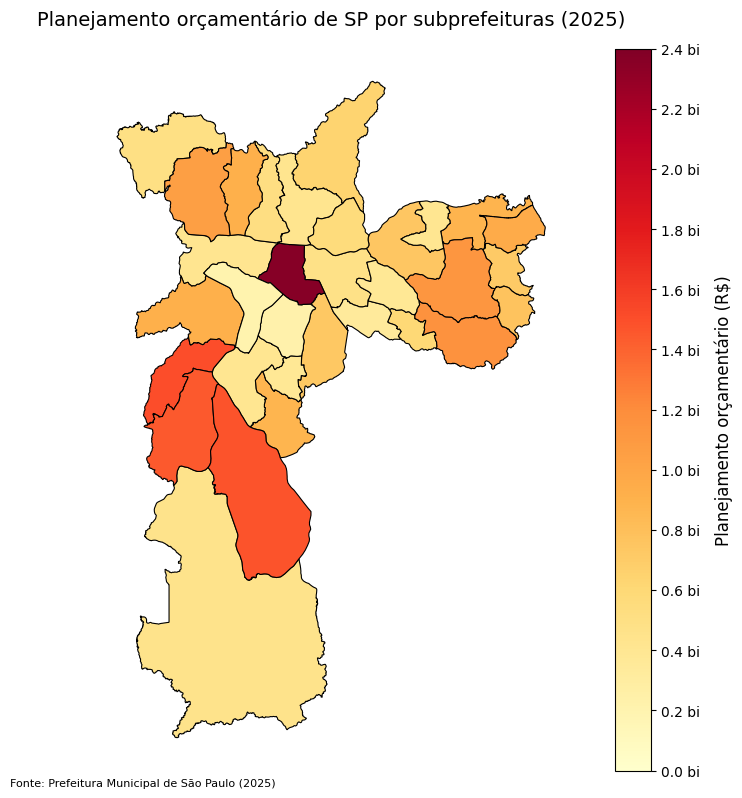

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

gdf_mapa.plot(column = "valor 2025",
              cmap = "YlOrRd",
              linewidth = 0.8,
              edgecolor = "black",
              legend = True,
              ax = ax,
              vmin = 0,
              vmax = 2.4e9)

ax.set_title("Planejamento orçamentário de SP por subprefeituras (2025)", fontsize = 14)

colorbar = ax.get_figure().get_axes()[1]

ticks = np.arange(0, 2.5e9, 0.2e9)

colorbar.yaxis.set_ticks(ticks)

colorbar.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.1f} bi'))

colorbar.set_ylabel("Planejamento orçamentário (R$)", fontsize = 12, labelpad = 10)

colorbar.set_ylim(0, 2.4e9)

plt.figtext(0.5, 0.01,
            "Fonte: Prefeitura Municipal de São Paulo (2025)",
            ha = "right",
            fontsize = 8)

ax.axis("off")

plt.tight_layout()

plt.show()

save_graph(fig, "mapa_ppa_2025.png")

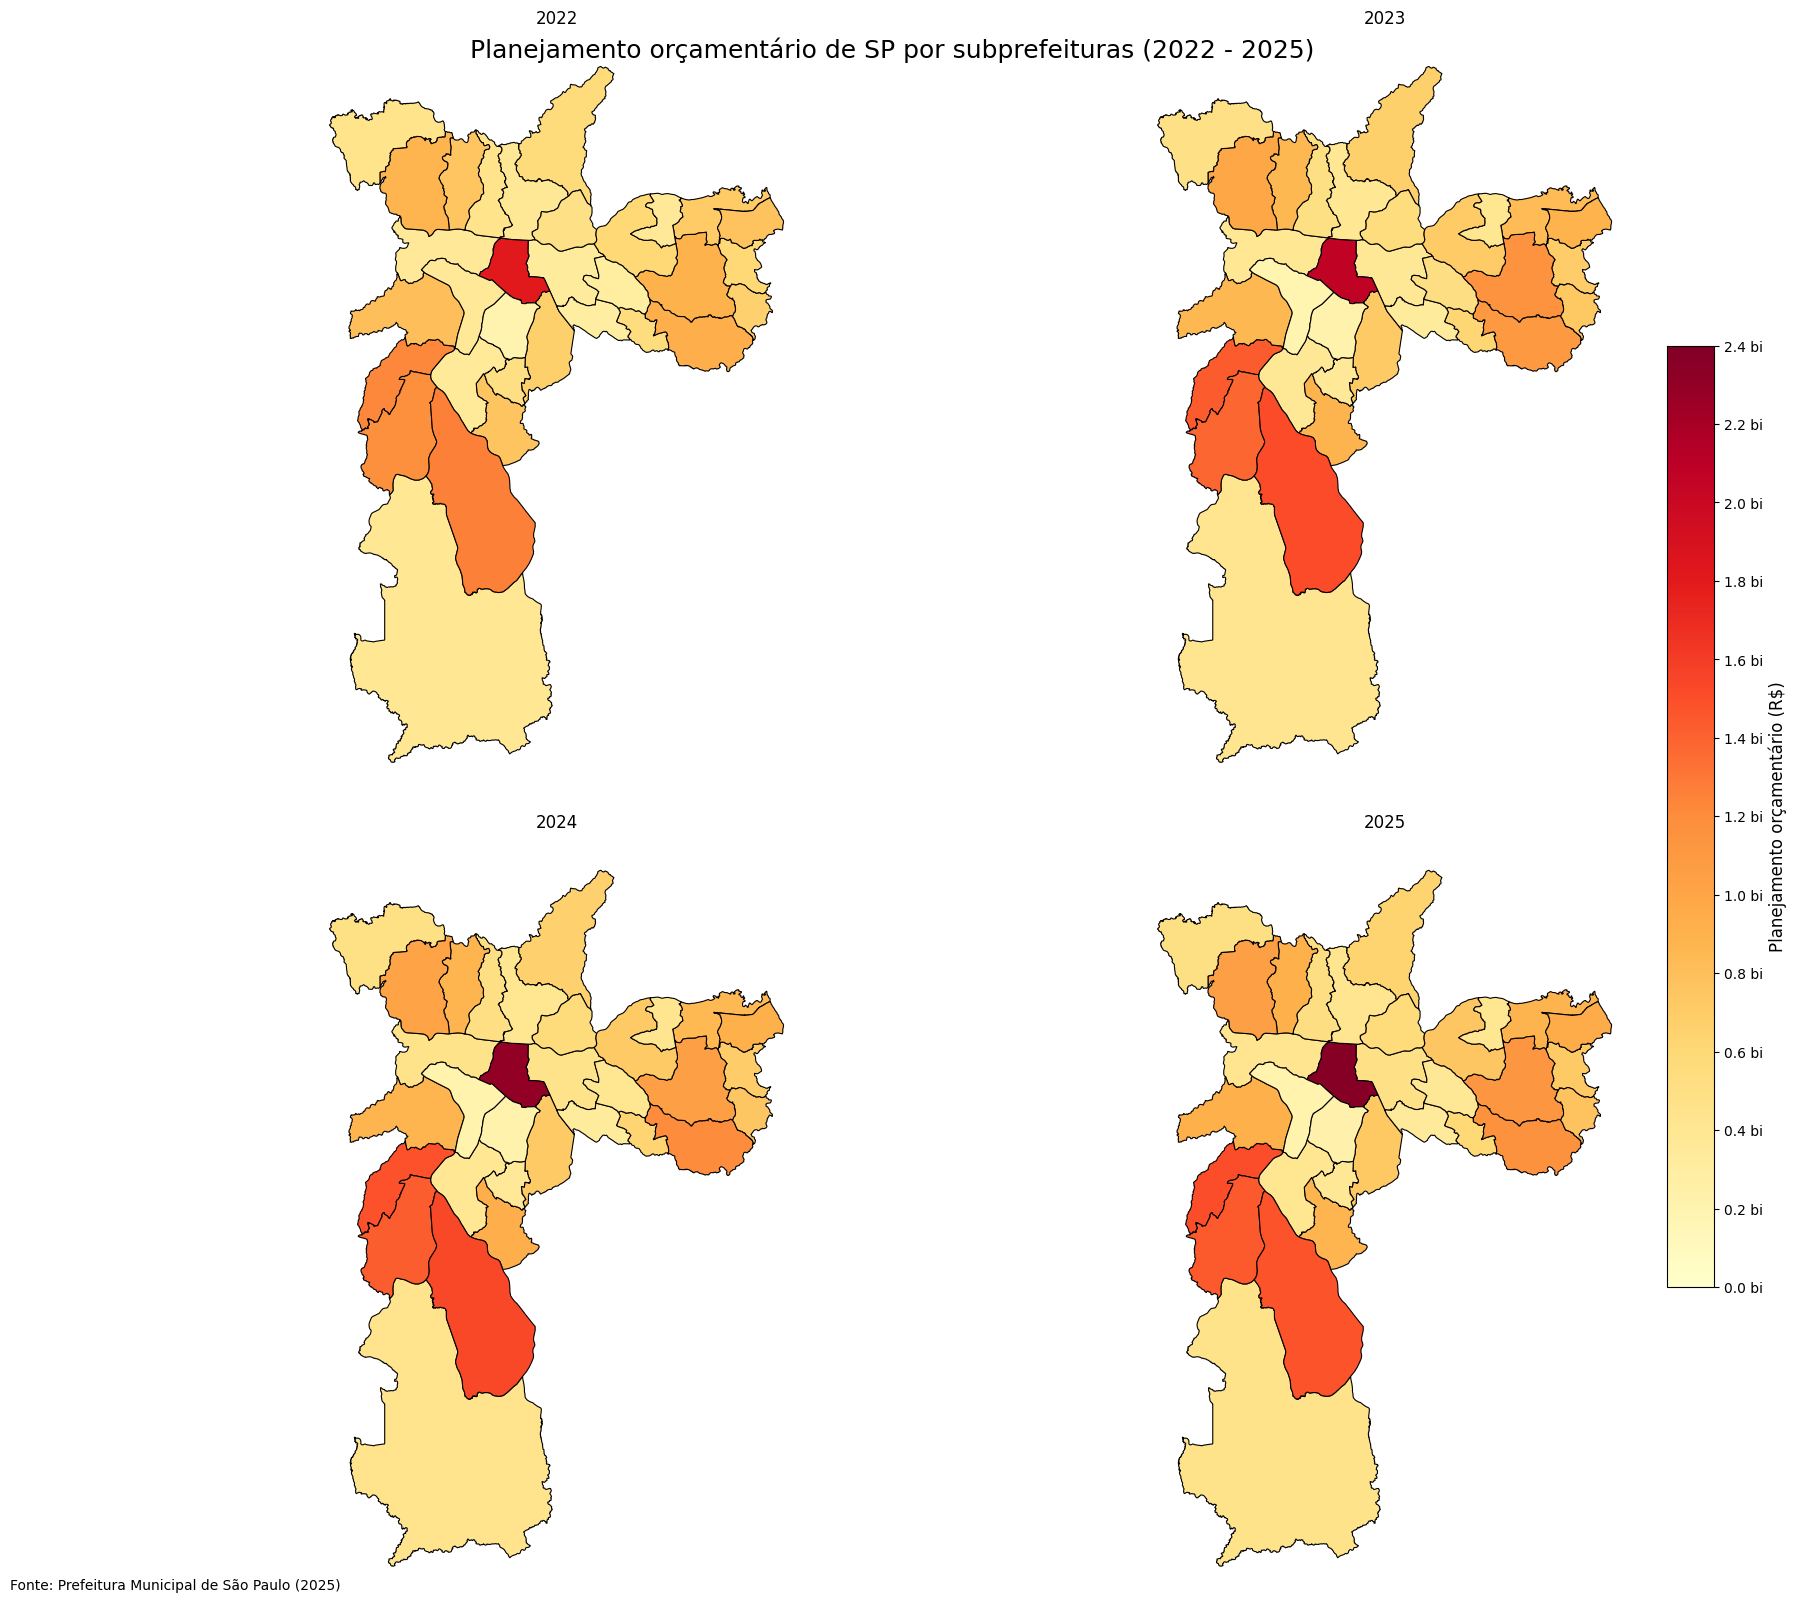

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(18, 16), constrained_layout=True)

# Dados
anos = ["2022", "2023", "2024", "2025"]
colunas = ["valor 2022", "valor 2023", "valor 2024", "valor 2025"]
vmin, vmax = 0, 2.4e9

# Plot dos mapas
for ax, ano, coluna in zip(axs.flat, anos, colunas):
    gdf_mapa.plot(column=coluna,
                  cmap="YlOrRd",
                  linewidth=0.8,
                  edgecolor="black",
                  ax=ax,
                  vmin=vmin,
                  vmax=vmax)
    
    ax.set_title(f"{ano}", fontsize=12)
    ax.axis("off")

# Colorbar única
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, ax=axs, orientation="vertical", shrink=0.6, pad=0.02)
ticks = np.arange(0, 2.5e9, 0.2e9)
cbar.set_ticks(ticks)
cbar.ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:.1f} bi'))
cbar.set_label("Planejamento orçamentário (R$)", fontsize=12)

# Título geral
fig.suptitle("Planejamento orçamentário de SP por subprefeituras (2022 - 2025)", fontsize=18, y=0.98)

# Fonte no canto inferior esquerdo
fig.text(0.01, 0.01, "Fonte: Prefeitura Municipal de São Paulo (2025)", 
         ha="left", fontsize=10)

# Ajuste final
plt.show()

save_graph(fig, "mapa_ppa_juntos.png")
